# Introdução.

* A Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada.

# Descrição do projeto
 * Após a exclusão e modificação de algumas variáveis, foi visto que o desempenho do modelo padrão de machine learning passou de um MAPE de 5.86092 Std: 0.96943 Error: 0.43354  para um de 5.79653 Std: 0.93450 Erro: 0.41792. E o número de variáveis foi de 32 para 20.
 
* Logo, nessa parte deste trabalho será visto o turing dos parâmetros de diversos modelos de machine learning. E também será medido o desempenho deles através dos dados de teste.
* A estratégia utilizada para realizar o que foi proposto, segue os seguintes passos:
* Separação dos dados em Teste e Validação.
  * Validação: 2013/01/01 - 2015/06/18.
  * Teste: 2015/06/19 - 2015/07/31.
  * A Validação será feita para tunar os modelos de machine learning e ela será feita método prequential Expanding.
* Os modelos serão avaliados nas seguintes métricas:
  * MAPE - Erro médio Absoluto Percentual.
  * RMSLE - Raiz do erro médio quadrático considerando o log.
  * RMSE - Raiz do erro médio quadrático.
* Modelos utilizados:
  * Random Forest.
  * LGBM.
  * Decision Tree.
---
  * **Os dados de teste serão utilizados para simular o ambiente real no qual o modelo de machine learning será aplicado. (Parte final para decidir qual o melhor modelo)**
---
 
 


# Descrição dos dados.

* Os dados foram obtidos do kaggle:
 * https://www.kaggle.com/c/rossmann-store-sales
 
 
* Descrição dos arquivos utilizados :
* **train.csv** - historical data including Sales
* **test.csv** - historical data excluding Sales
* **store.csv** - supplemental information about the stores
* **Os dados utilizados veio do tratamento feito nos arquivos train,test,store**.
 
* Legenda:
 * **[T]** - Dados veio do arquivo Train.
 * **[S]** - Dados veio do arquivo do Store.
 * **[C]** - Criado pelo notebook Tratamento dos dados.
 * **[D]** - Criado pelo notebook Descrição dos dados.
 * **[M]** - Criado pelo notebook Modification dataset
 * **[CD]** - Criado pelo notebook Codification dataset 
 
* Descrição dos dados.
* **day_of_week [T]** - Day of week.
* **date [T]** - days the data was acquired.
* **store [T]** - a unique Id for each store
* **sales [T]** - the turnover for any given day (this is what you are predicting) 
* **customers [T]** - the number of customers on a given day
* **store_type_a [M]** - store models a.
* **store_type_b [M]** - store models b.
* **store_type_c [M]** - store models c. 
* **competition_distance [S]** - distance in meters to the nearest competitor store.
* **competition_open_since_year [S]** - gives the approximate year of the time the nearest competitor was opened.
* **Promo [T]** - indicates whether a store is running a promo on that day
* **Promo2 [S]** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating.
* **promo2_since_year [S]** - describes the year  when the store started participating in Promo2.
* **year [C]** - year the data died.
* **week_year [C]**  - calendar week  the data died.
* **without_competition [C]** - Store has competition.
* **promo_time_week [C]** - Time the store works without the promotion.
* **Total_dias [CD]** - Accumulated days.
* **day_cos [CD]** - Day variable transformed into cosine sign.
* **holiday [CD]** - The day is a holiday or not. Where 1 is a holiday and 0 is a day that is not.
* **assortment [CD]** - Describe assortment level the store. 1 - > Extended, 2 ->  Estra, 3 -> basic.
 
 
 


# Instalando as bibliotecas.

In [2]:
!pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555`

/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [3]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.5 MB/s 


# Funções

In [4]:
def MAPE(y_pred,Y_teste):
  return np.mean(100*np.abs(y_pred - Y_teste)/np.abs(Y_teste))

def label_encoder(d,col):
  enc      = LabelEncoder()
  enc      = enc.fit(d[col])
  inteiros = enc.fit_transform(d[col])
  d[col]   = inteiros
  return d

def dummies_var(dados,coluna):
  df_aux = dados
  df_aux = df_aux.join(pd.get_dummies(df_aux[coluna], prefix=coluna))
  df_aux = df_aux.drop(columns=coluna)
  return df_aux


def validation(X,Y,coluna,flag,Date,model):
  vetor_MAPE = np.zeros(5) 
  vetor_MSLR = np.zeros(5)
  vetor_RMSE = np.zeros(5)
  Y_pred = []
  Y_val  = []
  for i in range(5):
    # Dados de treinamento
 
    X_t = X[X['Total_dias']  < 689 + 6*7*i]
    y_t = Y[coluna][Y['Total_dias']  < 689 + 6*7*i]
    X_t = X_t.drop(columns = ['Total_dias'])
    
    # Dados de validação
    X_v = X[(X['Total_dias'] >= 689 + 6*7*i) & (X['Total_dias'] <= 689 + 6*7*(i+1))]
    y_v = Y[coluna][(Y['Total_dias'] >= 689 + 6*7*i) & (Y['Total_dias'] <= 689 + 6*7*(i+1))]
    X_v = X_v.drop(columns = ['Total_dias'])
    
    md        = model.fit(X_t, y_t)
    y_pred    = md.predict(X_v)
    
    if flag == 'log':
      y_pred = np.round(10**y_pred - 1)  # eliminar o ruído provocado pelo computados atravez dou round
      y_v    = np.round(10**y_v - 1)
    if flag == 'sqrt':
      y_pred = np.round(y_pred**2)
      y_v    = np.round(y_v**2)
    if flag == 'normal':
      y_pred = y_pred
      y_v    = y_v
    
  
    
    mape = MAPE(y_v,y_pred)
    mslr = mean_squared_log_error(y_v,y_pred)
    rmse = mean_squared_error(y_v,y_pred,squared =False)
    
    vetor_MAPE[i] = mape
  
  return np.mean(vetor_MAPE)


def dados_teste_val(df):
  val   = df.copy()
  test  = df.copy()
  
  val  = val[val['date'] < '2015-06-19']     # Dados de validação
  test = test[test['date'] >= '2015-06-19']  # Dados de teste
  Date = val['date']
  df.index = np.arange(df.shape[0])
  X = val.drop(columns = ['date','sales'])
  Y = val[['sales','Total_dias']]

  return X,Y,Date


def Tuning_RF(params):
  max_depth = params[0]
  n_estimators = params[1]  
  max_features = params[2]
  
  print('max_depth:',params[0])
  print('n_estimators:',params[1])
  print('max_features:',params[2])

  model = RandomForestRegressor(n_estimators = n_estimators,max_depth=max_depth,max_features = max_features,random_state = 42) # modelo padrão
  mape = validation(X,Y,'sales','normal',Date,model)
  return mape


def Tuning_AD(params):
 
  max_depth = params[0]
  min_samples_split = params[1]
  max_features = params[2]
  min_samples_leaf = params[3]

  print('max_depth:',params[0])
  print('min_samples_split:',params[1])
  print('max_features:',params[2])
  print('min_samples_leaf:',params[3])

  
  model = DecisionTreeRegressor(random_state=42,min_samples_leaf = min_samples_leaf,max_depth = max_depth ,max_features =max_features,min_samples_split = min_samples_split)
  mape = validation(X,Y,'sales','normal',Date,model)


  return mape

def Tuning_LGBM(params):
  lr = params[0]
  max_depth = params[1]
  n_estimators = params[2]
  colsample_bytree = params[3]
  lamb             = params[4]
  alpha            = params[5]


  print('lr:',params[0])
  print('max_depth:',params[1])
  print('n_estimators:',params[2])
  print('colsample_bytree:',params[3])
  print('reg_lambda:',params[4])
  print('reg_alpha:',params[5])

  
  model = LGBMRegressor(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         n_estimators=n_estimators, random_state=40, 
                         n_jobs=6)

  mape = validation(X,Y,'sales','normal',Date,model)
  return mape



def validation1(X,Y,coluna,flag,Date,model):
  vetor_MAPE = np.zeros(5) 
  vetor_MSLR = np.zeros(5)
  vetor_RMSE = np.zeros(5)
  Y_pred = []
  Y_val  = []
  for i in range(5):
    # Dados de treinamento
    print('Data do inicio do treinamento:', Date[X['Total_dias'] < 689 + 6*7*i].dt.date.values[0],
          'Data do final do treinamento :',Date[X['Total_dias'] < 689 + 6*7*i].dt.date.values[-1])
  
    
    X_t = X[X['Total_dias']  < 689 + 6*7*i]
    y_t = Y[coluna][Y['Total_dias']  < 689 + 6*7*i]
    X_t = X_t.drop(columns = ['Total_dias'])
    
    # Dados de validação
    print('Data do inicio do Validação  :', Date[(X['Total_dias'] >= 689 + 6*7*i) & (X['Total_dias'] <= 689 + 6*7*(i+1))].dt.date.values[0],
          'Data do final do Validação   :',Date[(X['Total_dias'] >= 689 + 6*7*i) & (X['Total_dias'] <= 689 + 6*7*(i+1))].dt.date.values[-1])

    X_v = X[(X['Total_dias'] >= 689 + 6*7*i) & (X['Total_dias'] <= 689 + 6*7*(i+1))]
    y_v = Y[coluna][(Y['Total_dias'] >= 689 + 6*7*i) & (Y['Total_dias'] <= 689 + 6*7*(i+1))]
    X_v = X_v.drop(columns = ['Total_dias'])
    
    md        = model.fit(X_t, y_t)
    y_pred    = md.predict(X_v)
    
    if flag == 'log':
      y_pred = np.round(10**y_pred - 1)  # eliminar o ruído provocado pelo computados atravez dou round
      y_v    = np.round(10**y_v - 1)
    if flag == 'sqrt':
      y_pred = np.round(y_pred**2)
      y_v    = np.round(y_v**2)
    if flag == 'normal':
      y_pred = y_pred
      y_v    = y_v
    
  
    
    mape = MAPE(y_v,y_pred)
    mslr = mean_squared_log_error(y_v,y_pred)
    rmse = mean_squared_error(y_v,y_pred,squared =False)
    vetor_MAPE[i] = mape
    vetor_MSLR[i] = mslr
    vetor_RMSE[i] = rmse
  
    print('MAPE: ',np.format_float_positional(mape,5))
    print('RMSLE:',np.format_float_positional(mslr,5))
    print('RMSE: ',np.format_float_positional(rmse,5))
     
   
  print('Mape Geral: ',np.format_float_positional(np.mean(vetor_MAPE),5),'Std:',np.format_float_positional(np.std(vetor_MAPE),5),'Erro:',np.format_float_positional(np.std(vetor_MAPE)/np.sqrt(5),5))
  print('Rmsle Geral:',np.format_float_positional(np.mean(vetor_MSLR),5),'Std:',np.format_float_positional(np.std(vetor_MSLR),5),'Erro:',np.format_float_positional(np.std(vetor_MSLR)/np.sqrt(5),5))
  print('Rmse Geral: ',np.format_float_positional(np.mean(vetor_RMSE),5),'Std:',np.format_float_positional(np.std(vetor_RMSE),5),'Erro:',np.format_float_positional(np.std(vetor_RMSE)/np.sqrt(5),5))
  return vetor_MAPE,vetor_MSLR,vetor_RMSE

def Tuning_XGBR1(params):
  lr = params[0]
  max_depth = params[1]
  n_estimators = params[2]
  colsample_bytree = params[3]
  lamb             = params[4]
  alpha            = params[5]


  print('lr:',params[0])
  print('max_depth:',params[1])
  print('n_estimators:',params[2])
  print('colsample_bytree:',params[3])
  print('reg_lambda:',params[4])
  print('reg_alpha:',params[5])

  
  model = XBGB.XGBRegressor(objective='reg:squarederror',colsample_bytree = colsample_bytree, learning_rate = lr,
                       max_depth = max_depth, n_estimators = n_estimators,reg_lambda = lamb, reg_alpha = alpha,random_state=40)
  mape = validation(X,Y,'sales','normal',Date,model)
  return mape

def erro_interval(y_pred,Y_test):
  confidence = 0.90
  erro = Y_test['sales'] - y_pred
  erro_m = stats.t.interval(confidence,len(erro)-1,loc = erro.mean(),scale = stats.sem(erro))[1] - np.mean(erro)

  confidence = 0.90
  erro = 100*np.abs(y_pred - Y_test['sales'])/np.abs(Y_test['sales'])
  erro_s = stats.t.interval(confidence,len(erro)-1,loc = erro.mean(),scale = stats.sem(erro))[1] - np.mean(erro)

  return erro_s,erro_m



# Biblioteca

In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error,mean_squared_error
import skopt
from skopt import gp_minimize, forest_minimize
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as XBGB
from sklearn.tree import DecisionTreeRegressor
from scipy import stats

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importando os dados.

In [6]:
df = pd.read_csv('/content/drive/My Drive/dados/time series/dados_novos3.csv')

In [7]:
df.head() # vendo os dados

,Unnamed: 0,store,day_of_week,date,sales,customers,promo,competition_distance,competition_open_since_year,promo2,...,year,week_year,promo_time_week,Total_dias,store_type_a,store_type_b,store_type_c,day_cos,holiday,assortment
0,0,1115,4,2013-01-03,4297,300,0,5350.0,2013,1,...,2013,1,32,3.0,0,0,0,0.809017,0.0,1.0
1,1,1114,4,2013-01-03,18463,3211,0,870.0,2013,0,...,2013,1,0,3.0,1,0,0,0.809017,0.0,1.0
2,2,1113,4,2013-01-03,5563,718,0,9260.0,2013,0,...,2013,1,0,3.0,1,0,0,0.809017,0.0,1.0
3,3,1112,4,2013-01-03,8716,809,0,1880.0,2006,0,...,2013,1,0,3.0,0,0,1,0.809017,0.0,1.0
4,4,1111,4,2013-01-03,4579,444,0,1900.0,2014,1,...,2013,1,-30,3.0,1,0,0,0.809017,0.0,0.0


In [8]:
df = df.drop(columns = ['Unnamed: 0'])

In [9]:
df.head()

,store,day_of_week,date,sales,customers,promo,competition_distance,competition_open_since_year,promo2,promo2_since_year,...,year,week_year,promo_time_week,Total_dias,store_type_a,store_type_b,store_type_c,day_cos,holiday,assortment
0,1115,4,2013-01-03,4297,300,0,5350.0,2013,1,2012,...,2013,1,32,3.0,0,0,0,0.809017,0.0,1.0
1,1114,4,2013-01-03,18463,3211,0,870.0,2013,0,2013,...,2013,1,0,3.0,1,0,0,0.809017,0.0,1.0
2,1113,4,2013-01-03,5563,718,0,9260.0,2013,0,2013,...,2013,1,0,3.0,1,0,0,0.809017,0.0,1.0
3,1112,4,2013-01-03,8716,809,0,1880.0,2006,0,2013,...,2013,1,0,3.0,0,0,1,0.809017,0.0,1.0
4,1111,4,2013-01-03,4579,444,0,1900.0,2014,1,2013,...,2013,1,-30,3.0,1,0,0,0.809017,0.0,0.0


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.index = np.arange(df.shape[0])

# Valor MAPE do modelo padrão

In [12]:
model    = RandomForestRegressor(n_estimators = 10,random_state = 10) 

In [13]:
X ,Y,Date = dados_teste_val(df)

In [14]:
validation(X,Y,'sales','normal',Date,model)

5.796533580972606

# Tuning dos modelos
 
 
 
 


### Random Forest.

In [ ]:
X ,Y,Date = dados_teste_val(df)

In [ ]:
space = [(1,25), # max_depth
        (10,200),  #n_estimator
        (2,18)]   #max_features


In [ ]:
#X.columns

In [ ]:
res1 = gp_minimize(Tuning_RF, space, random_state=40, n_calls=16, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
max_depth: 16
n_estimators: 31
max_features: 13
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 369.5704
Function value obtained: 6.8512
Current minimum: 6.8512
Iteration No: 2 started. Evaluating function at random point.
max_depth: 4
n_estimators: 121
max_features: 4
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 175.2183
Function value obtained: 20.2651
Current minimum: 6.8512
Iteration No: 3 started. Evaluating function at random point.
max_depth: 5
n_estimators: 183
max_features: 4
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 322.3107
Function value obtained: 18.8393
Current minimum: 6.8512
Iteration No: 4 started. Evaluating function at random point.
max_depth: 13
n_estimators: 110
max_features: 15
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1300.7174
Function value obtained: 8.7122
Current minimum: 6.8512
Iteration No: 5 started. E

In [ ]:
print('Best Value:',res1.fun)
print('Parâmetros:',res1.x)

Best Value: 5.312410657732713
Parâmetros: [25, 200, 12]


* Aumentando o número de arvores para ver o desepenho do modelo.

In [ ]:
model                                = RandomForestRegressor(max_depth = 25 ,n_estimators = 200,max_features = 12,random_state = 42) 
vetor_MAPE1,vetor_MSLR1,vetor_RMSE1  = validation1(X,Y,'sales','normal',Date,model)

Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2014-11-19
Data do inicio do Validação  : 2014-11-20 Data do final do Validação   : 2015-01-01
MAPE:  6.91207
RMSLE: 0.00770
RMSE:  798.65639
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2014-12-31
Data do inicio do Validação  : 2015-01-01 Data do final do Validação   : 2015-02-12
MAPE:  4.90085
RMSLE: 0.00424
RMSE:  464.28865
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-02-11
Data do inicio do Validação  : 2015-02-12 Data do final do Validação   : 2015-03-26
MAPE:  4.48690
RMSLE: 0.00332
RMSE:  381.37186
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-03-25
Data do inicio do Validação  : 2015-03-26 Data do final do Validação   : 2015-05-07
MAPE:  5.39674
RMSLE: 0.00490
RMSE:  629.24675
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-05-06
Data do inicio do Validação  : 2015-05-07 Data do final 

### LGBM



In [ ]:
space = [(1e-3, 1e-1), # lr
          (1, 10),     # max_depth
          (100,1000),  # n_estimator
          (0,1),       # colsample_bytree
          (0,1e-3),    # reg_lambda
          (0,1e-3)]    # reg_alpha

res2 = gp_minimize(Tuning_LGBM, space, random_state=0, n_calls=20, verbose=1)


Iteration No: 1 started. Evaluating function at random point.
lr: 0.05969161720427683
max_depth: 9
n_estimators: 872
colsample_bytree: 1
reg_lambda: 0.0006235636967859725
reg_alpha: 0.00038438170729269993
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 633.0245
Function value obtained: 4.8908
Current minimum: 4.8908
Iteration No: 2 started. Evaluating function at random point.
lr: 0.030455926047902763
max_depth: 2
n_estimators: 345
colsample_bytree: 0
reg_lambda: 0.0008121687287754935
reg_alpha: 0.00047997717237505745
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 52.0979
Function value obtained: 12.1630
Current minimum: 4.8908
Iteration No: 3 started. Evaluating function at random point.
lr: 0.03988569481398216
max_depth: 9
n_estimators: 404
colsample_bytree: 1
reg_lambda: 0.000368241539840548
reg_alpha: 0.0009571551589530466
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 356.1424
Function value obtained: 5.3896
Current min

In [ ]:
print('Best Value:',res2.fun)
print('Parâmetros:',res2.x)

Best Value: 4.829339632771914
Parâmetros: [0.07050672582272845, 9, 855, 1, 0.00039939957529561544, 0.0006803520566543689]


In [ ]:
lr = 0.07050672582272845
max_depth  = 9
n_estimators = 855
colsample_bytree = 1
lamb             = 0.00039939957529561544
alpha            =  0.0006803520566543689

model = LGBMRegressor(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         n_estimators=n_estimators, random_state=40, 
                         n_jobs=6)



In [ ]:
vetor_MAPE3,vetor_MSLR3,vetor_RMSE3  = validation1(X,Y,'sales','normal',Date,model)

Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2014-11-19
Data do inicio do Validação  : 2014-11-20 Data do final do Validação   : 2015-01-01
MAPE:  5.00496
RMSLE: 0.00444
RMSE:  547.7933
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2014-12-31
Data do inicio do Validação  : 2015-01-01 Data do final do Validação   : 2015-02-12
MAPE:  4.97095
RMSLE: 0.00436
RMSE:  455.88904
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-02-11
Data do inicio do Validação  : 2015-02-12 Data do final do Validação   : 2015-03-26
MAPE:  4.65856
RMSLE: 0.00351
RMSE:  386.34936
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-03-25
Data do inicio do Validação  : 2015-03-26 Data do final do Validação   : 2015-05-07
MAPE:  5.08405
RMSLE: 0.00459
RMSE:  581.07289
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-05-06
Data do inicio do Validação  : 2015-05-07 Data do final d

### Decision Tree

In [ ]:
space = [(1,35),  # max_depth
        (2,20),   #min_samples_split
        (2,18),   #max_features
        (2,20)]  #min_samples_leaf 


In [ ]:
res3 = gp_minimize(Tuning_AD, space, random_state=40, n_calls=30, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
max_depth: 23
min_samples_split: 4
max_features: 13
min_samples_leaf: 5
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 19.9904
Function value obtained: 7.1044
Current minimum: 7.1044
Iteration No: 2 started. Evaluating function at random point.
max_depth: 21
min_samples_split: 4
max_features: 5
min_samples_leaf: 18
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.8163
Function value obtained: 10.1522
Current minimum: 7.1044
Iteration No: 3 started. Evaluating function at random point.
max_depth: 4
min_samples_split: 11
max_features: 10
min_samples_leaf: 17
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.1817
Function value obtained: 19.5050
Current minimum: 7.1044
Iteration No: 4 started. Evaluating function at random point.
max_depth: 15
min_samples_split: 7
max_features: 6
min_samples_leaf: 9
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 24.1991
Function value obtained: 7.0598
Current minimum: 6.9959
Iteration No: 19 started. Searching for the next optimal point.
max_depth: 34
min_samples_split: 20
max_features: 15
min_samples_leaf: 2
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 22.7318
Function value obtained: 6.8806
Current minimum: 6.8806
Iteration No: 20 started. Searching for the next optimal point.
max_depth: 22
min_samples_split: 20
max_features: 8
min_samples_leaf: 2
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 13.7002
Function value obtained: 7.6396
Current minimum: 6.8806
Iteration No: 21 started. Searching for the next optimal point.
max_depth: 35
min_samples_split: 20
max_features: 18
min_samples_leaf: 2
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 27.3177
Function value obtained: 6.8345
Current minimum: 6.8345
Iteration No: 

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 27.4192
Function value obtained: 6.9663
Current minimum: 6.8345
Iteration No: 28 started. Searching for the next optimal point.
max_depth: 23
min_samples_split: 2
max_features: 18
min_samples_leaf: 5


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 27.8555
Function value obtained: 6.9663
Current minimum: 6.8345
Iteration No: 29 started. Searching for the next optimal point.
max_depth: 23
min_samples_split: 2
max_features: 18
min_samples_leaf: 5


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 27.3107
Function value obtained: 6.9663
Current minimum: 6.8345
Iteration No: 30 started. Searching for the next optimal point.
max_depth: 28
min_samples_split: 20
max_features: 18
min_samples_leaf: 2
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 27.1486
Function value obtained: 6.8338
Current minimum: 6.8338


In [ ]:
print('Best Value:',res3.fun)
print('Parâmetros:',res3.x)

Best Value: 6.83379555949916
Parâmetros: [28, 20, 18, 2]


In [ ]:
max_depth = 28
min_samples_split = 20
max_features = 18
min_samples_leaf = 2

model = DecisionTreeRegressor(random_state=42,min_samples_leaf = min_samples_leaf,max_depth = max_depth ,max_features =max_features,min_samples_split = min_samples_split)


vetor_MAPE4,vetor_MSLR4,vetor_RMSE4  = validation1(X,Y,'sales','normal',Date,model)

Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2014-11-19
Data do inicio do Validação  : 2014-11-20 Data do final do Validação   : 2015-01-01
MAPE:  9.24074
RMSLE: 0.01386
RMSE:  1069.40728
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2014-12-31
Data do inicio do Validação  : 2015-01-01 Data do final do Validação   : 2015-02-12
MAPE:  6.35778
RMSLE: 0.00780
RMSE:  622.44664
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-02-11
Data do inicio do Validação  : 2015-02-12 Data do final do Validação   : 2015-03-26
MAPE:  5.70343
RMSLE: 0.0057
RMSE:  496.57368
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-03-25
Data do inicio do Validação  : 2015-03-26 Data do final do Validação   : 2015-05-07
MAPE:  6.72099
RMSLE: 0.00785
RMSE:  773.72029
Data do inicio do treinamento: 2013-01-03 Data do final do treinamento : 2015-05-06
Data do inicio do Validação  : 2015-05-07 Data do final 

### Avaliando os resultados


* Legenda:
  * v0 -> Random Forest.
  * v1 -> Lgbm
  * v2 -> Decision Tree
  
---
---
* Mape Geral v0:  5.31241 Std: 0.85048 Erro: 0.38035
* Mape Geral v1:  4.82927 Std: 0.24745 Erro: 0.11066
* Mape Geral v2:  6.83380 Std: 1.24767 Erro: 0.55798

---
---
* Rmsle Geral v0:  0.00481 Std: 0.00153 Erro: 0.00069
* Rmsle Geral v1:  0.00406 Std: 0.00050 Erro: 0.00022
* Rmsle Geral v2:  0.00833 Std: 0.00289 Erro: 0.00129
---
---
* Rmse Geral v0: 549.36019 Std: 148.17719 Erro: 66.26685
* Rmse Geral v1: 479.60477 Std: 73.457780 Erro: 32.85132
* Rmse Geral v2: 715.71035 Std: 197.50820 Erro: 88.32835
---
---



# Erro de teste

### Modelos

In [11]:
val   = df.copy()
test  = df.copy()
  
val  = val[val['date'] < '2015-06-19']     # Dados de validação
test = test[test['date'] >= '2015-06-19']  # Dados de teste
Date = val['date']
df.index = np.arange(df.shape[0])
X = val.drop(columns = ['date','sales'])
Y = val[['sales','Total_dias']]

X_test = test.drop(columns = ['date','sales'])
Y_test = test[['sales','Total_dias']]

In [12]:
# Random forest
model1 = RandomForestRegressor(max_depth = 25 ,n_estimators = 200,max_features = 12,random_state = 42) 
md         = model1.fit(X.drop(columns=['Total_dias']),Y.drop(columns = ['Total_dias']))
y_pred1    = md.predict(X_test.drop(columns=['Total_dias']))

del model1,md

# LGBM
lr = 0.07050672582272845
max_depth  = 9
n_estimators = 855
colsample_bytree = 1
lamb             = 0.00039939957529561544
alpha            =  0.0006803520566543689

model2 = LGBMRegressor(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         n_estimators=n_estimators, random_state=40, n_jobs=6)
md       = model2.fit(X.drop(columns=['Total_dias']),Y.drop(columns = ['Total_dias']))
y_pred2  = md.predict(X_test.drop(columns=['Total_dias']))


del model2,md

# Decision Tree
max_depth = 28
min_samples_split = 20
max_features = 18
min_samples_leaf = 2

model3 = DecisionTreeRegressor(random_state=42,min_samples_leaf = min_samples_leaf,max_depth = max_depth ,max_features =max_features,min_samples_split = min_samples_split)

md       = model3.fit(X.drop(columns=['Total_dias']),Y.drop(columns = ['Total_dias']))
y_pred3  = md.predict(X_test.drop(columns=['Total_dias']))

del md,model3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
erro1,erro_m1 = erro_interval(y_pred1,Y_test)
print('Random Forest')
print('bias:',np.format_float_positional(np.mean(Y_test['sales'] - y_pred1),3),'erro:',
            np.format_float_positional(erro_m1,3))
print('MAPE:',np.format_float_positional(MAPE(Y_test['sales'],y_pred1),3),'erro:',
      np.format_float_positional(erro1,3))

erro2,erro_m2 = erro_interval(y_pred2,Y_test)
print('LGBM')
print('bias:',np.format_float_positional(np.mean(Y_test['sales'] - y_pred2),3),'erro:',
            np.format_float_positional(erro_m2,3))
print('MAPE:',np.format_float_positional(MAPE(Y_test['sales'],y_pred2),3),'erro:',
      np.format_float_positional(erro2,3))

erro3,erro_m3 = erro_interval(y_pred3,Y_test)
print('Decision Tree')

print('bias:',np.format_float_positional(np.mean(Y_test['sales'] - y_pred3),3),'erro:',
            np.format_float_positional(erro_m3,3))
print('MAPE:',np.format_float_positional(MAPE(Y_test['sales'],y_pred3),3),'erro:',
      np.format_float_positional(erro3,3))

Random Forest
bias: 182.365 erro: 4.435
MAPE: 5.341 erro: 0.038
LGBM
bias: 15.79 erro: 3.998
MAPE: 4.571 erro: 0.037
Decision Tree
bias: 225.898 erro: 3.998
MAPE: 6.794 erro: 0.037


# Desempenho dos modelos
 


In [ ]:
df_rf   = X_test.copy()
df_lg   = X_test.copy()
df_dt   = X_test.copy()

In [ ]:
df_rf['erro'] = 100*np.abs(y_pred1 - Y_test['sales'])/np.abs(Y_test['sales'])
df_lg['erro'] = 100*np.abs(y_pred2 - Y_test['sales'])/np.abs(Y_test['sales'])
df_dt['erro'] = 100*np.abs(y_pred3 - Y_test['sales'])/np.abs(Y_test['sales'])

df_rf['Pred'] = y_pred1
df_lg['Pred'] = y_pred2
df_dt['Pred'] = y_pred3

### Linearidade (Predição x Truth)

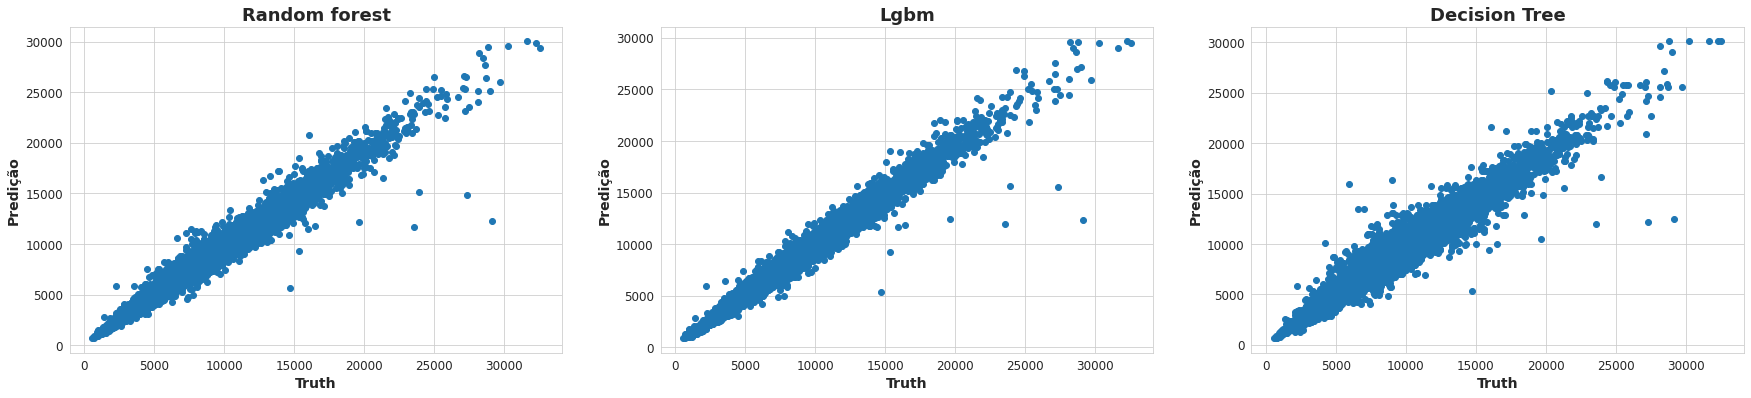

In [ ]:
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('Random forest',size=18,fontweight= 'bold')
plt.plot(Y_test['sales'],df_rf['Pred'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Predição', fontsize = 14,fontweight= 'bold')

plt.subplot(1,3,2)
plt.title('Lgbm',size=18,fontweight= 'bold')
plt.plot(Y_test['sales'],df_lg['Pred'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Predição', fontsize = 14,fontweight= 'bold')

plt.subplot(1,3,3)
plt.title('Decision Tree',size=18,fontweight= 'bold')
plt.plot(Y_test['sales'],df_dt['Pred'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Predição', fontsize = 14,fontweight= 'bold')

plt.show()

### Linearidade (Predição x Erro percentual)
 
 
 
 
 
 


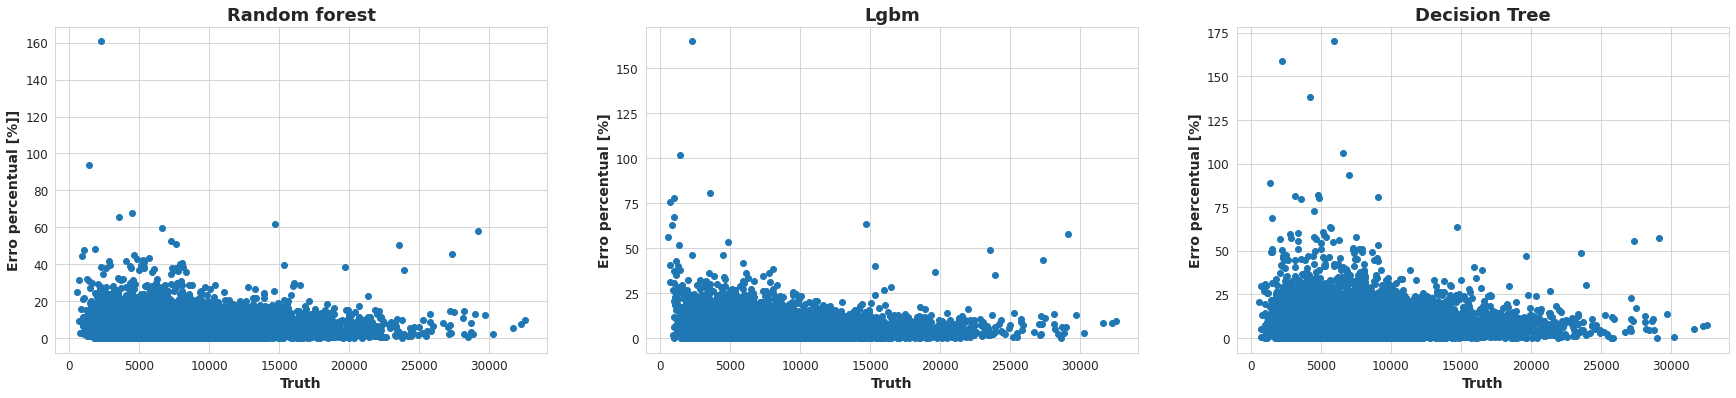

In [ ]:
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('Random forest',size=18,fontweight= 'bold')
plt.plot(Y_test['sales'],df_rf['erro'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Erro percentual [%]]', fontsize = 14,fontweight= 'bold')

plt.subplot(1,3,2)
plt.title('Lgbm',size=18,fontweight= 'bold')
plt.plot(Y_test['sales'],df_lg['erro'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Erro percentual [%]', fontsize = 14,fontweight= 'bold')

plt.subplot(1,3,3)
plt.title('Decision Tree',size=18,fontweight= 'bold')
plt.plot(Y_test['sales'],df_dt['erro'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Erro percentual [%]', fontsize = 14,fontweight= 'bold')

plt.show()

### Linearidade (store x Erro percentual)





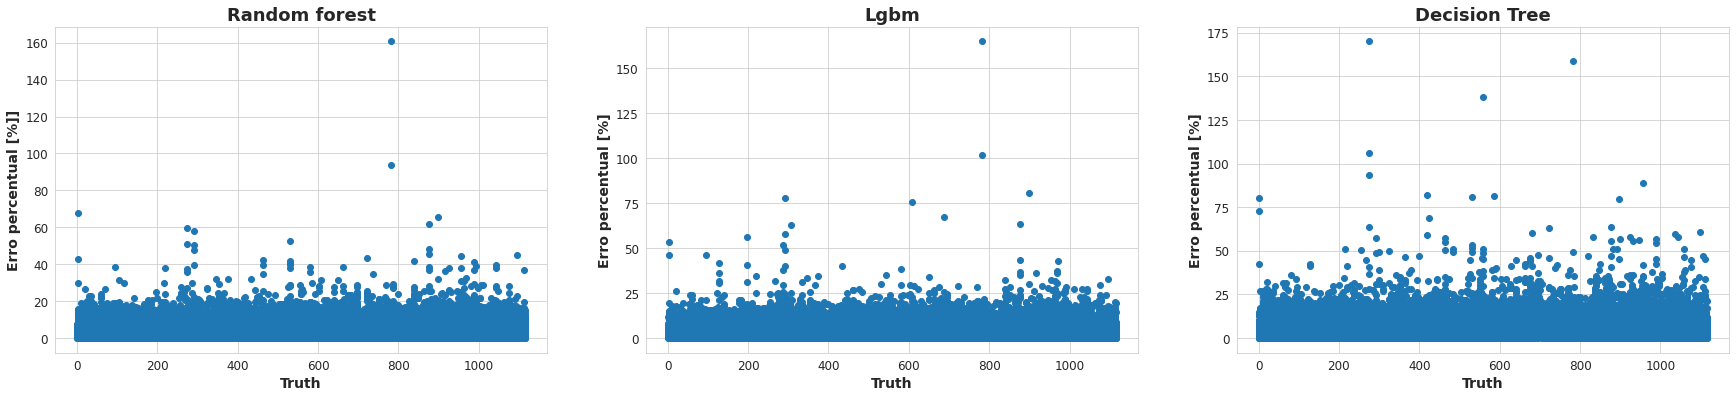

In [ ]:
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('Random forest',size=18,fontweight= 'bold')
plt.plot(df_rf['store'],df_rf['erro'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Erro percentual [%]]', fontsize = 14,fontweight= 'bold')

plt.subplot(1,3,2)
plt.title('Lgbm',size=18,fontweight= 'bold')
plt.plot(df_lg['store'],df_lg['erro'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Erro percentual [%]', fontsize = 14,fontweight= 'bold')

plt.subplot(1,3,3)
plt.title('Decision Tree',size=18,fontweight= 'bold')
plt.plot(df_dt['store'],df_dt['erro'],'o')
plt.xlabel('Truth', fontsize = 14,fontweight= 'bold')
plt.ylabel('Erro percentual [%]', fontsize = 14,fontweight= 'bold')

plt.show()

* Análise visual permitiu notar que havia alguns valores que podiam ser encarados pelo modelo como outliers. Sendo que os seus valores estão acontecendo acima de um erro percentual de 20 porcento. 
 
 
 


In [ ]:
print('Porcetagem de lojas que passaram de 20 % porcento:',100*len(df_lg['store'][df_lg['erro']>20].unique())/len(df_lg['store'].unique()))

Porcetagem de lojas que passaram de 20 % porcento: 11.657754010695188


# Conclusão.

* Nessa etapa foram encontradas as melhores configurações para cada modelo avaliado. E foi calculado o MAPE e BIAS de cada modelo com os dados de teste, para essas duas medidas o intervalo de confiança utilizado foi de 99%. Os valores encontrados estão sendo mostrados logo abaixo:
 
 * Random Forest:
   * BIAS : 182.365 erro: 4.435
   * MAPE: 5.34100 erro: 0.038
 * Lightgbm:
   * BIAS : 15.79 erro: 3.998
   * MAPE: 4.571 erro: 0.037
 * Decison Tree
   * BIAS : 225.898 erro: 3.998
   * MAPE: 6.794 erro: 0.037
 
* Pelos resultados obtidos o modelo que será utilizado para deploy é o Lightgbm, já que foi ele que obteve o menor erro. Entre um dos pontos fracos destes modelos é que o erro de algumas lojas está passando de 20%. 
 
 
 
